In [2]:
%load_ext autoreload
%autoreload 2

In [72]:
import numpy as np
import glob
import os
import pandas as pd
from enduse_comparison_functions import combine_enduse_from_csv, create_two_way_correspondences, create_enduse_by_country, check_enduse_integrity, transform_gloria_dict_to_df
from enduse_comparison_plots import country_all_enduses_panel

In [73]:
gloria_csv_path = os.path.join(os.getcwd(), "input_data", "GLORIA_basic_WIO_MF_EUT_end_use_shares_4_crosschecking")
csv_glob = os.path.join(gloria_csv_path, "*.csv")
csv_files = glob.glob(csv_glob)

In [74]:
all_enduses = combine_enduse_from_csv(csv_files)

In [75]:
gloria_exiobase_correspondence = pd.read_excel(os.path.join("input_data", "2023_GLORIA_EXIOBASE_corresp_aggr.xlsx"), sheet_name="values")

In [76]:
correspondences = gloria_exiobase_correspondence.to_dict("records")

In [77]:
correspondence_gloria_to_exio, correspondence_exio_to_gloria, equal_names = create_two_way_correspondences(correspondences)

In [78]:
country_material_enduse = create_enduse_by_country(all_enduses, gloria_exiobase_correspondence)

In [79]:
comparison_path = "GLORIA_EXIOBASE_SHIPMENT_VERGLEICH"
comparison_subfolder = "physical unit data + correspondence"
cao_filename = "Cao_2016_Cement_EndUseShares.xlsx"
cao_data = pd.read_excel(os.path.join(comparison_path, comparison_subfolder, cao_filename), sheet_name=None)
cao_correspondences = pd.read_excel(os.path.join(comparison_path, comparison_subfolder, "Cement_Cao_2016_Concordances.xlsx"), sheet_name=None)

In [80]:
country_correspondences = pd.read_excel(os.path.join(comparison_path, "MISO2_country_region_correspondence.xlsx"), sheet_name="values")

In [81]:
country_code_material_enduse = transform_gloria_dict_to_df(country_material_enduse, country_correspondences)

In [82]:
cao_index = ["Country", "Region"]
cao_enduses = cao_data["enduse_correspondence"]["CAO END_USES"].values
melted_df = pd.melt(cao_data["values"], id_vars=cao_index+["Year"],
                    value_vars=cao_enduses,
                    var_name="Enduse")

In [83]:
melted_df = melted_df.set_index(cao_index)

In [84]:
cao_by_country = melted_df.pivot_table(index=cao_index+["Enduse"], columns="Year", values="value")

In [85]:
cao_by_country["MISO2_Material"] = "Concrete"
cao_by_country = cao_by_country.set_index("MISO2_Material", append=True)

In [86]:
cao_enduse_correspondence = cao_data["enduse_correspondence"].to_dict(orient="records")

In [87]:
cao_gloria_correspondence = create_two_way_correspondences(cao_enduse_correspondence, "CAO END_USES", "GLORIA END_USES")

In [89]:
cao_by_country = cao_by_country.reset_index()
for cao_enduse, cao_enduse_list in cao_gloria_correspondence["CAO END_USES"].items():
    cao_by_country["Enduse"].replace({cao_enduse: cao_enduse_list}, inplace=True)

In [90]:
full_index = ["Country", "Region", "Enduse", "MISO2_Material"]
cao_by_country = cao_by_country.set_index(full_index)

In [91]:
cao_by_country = cao_by_country.groupby(full_index).sum()

In [92]:
cao_countries = cao_by_country.reset_index()[["Country"]]

In [94]:
miso_countries = cao_correspondences["region concordance"][["MISO2_name", "Source_name"]]

In [95]:
miso_countries.columns = ["MISO2_country", "Country"]

In [96]:
miso_countries = miso_countries.set_index("Country")

In [97]:
cao_by_country = cao_by_country.reset_index().set_index("Country")

In [99]:
joined_countries = miso_countries.join(cao_by_country, how="left")

In [100]:
joined_countries = joined_countries.reset_index().set_index(["MISO2_country", "Enduse", "MISO2_Material"])

In [101]:
joined_countries["source"] = "Cao 2016"

In [111]:
joined_countries.set_index("source",append=True,inplace=True)

In [188]:
gloria_subset_to_cao = country_code_material_enduse.loc[(slice(None), slice(None), list(cao_gloria_correspondence["GLORIA END_USES"].keys()), ["Concrete"])].copy()

In [189]:
gloria_subset_to_cao["source"] = "GLORIA"

In [114]:
gloria_subset_to_cao = gloria_subset_to_cao.reset_index().set_index(["MISO2_country", "Enduse", "MISO2_Material", "source"])

In [119]:
gloria_subset_to_cao = gloria_subset_to_cao.drop("Code ISO3166-1",axis=1)

In [128]:
gloria_subset_to_cao.columns = np.arange(1990,2021)

In [133]:
joined_countries = joined_countries.drop(["Country", "Region"], axis=1)

KeyError: "['Country', 'Region'] not found in axis"

In [135]:
joined_countries.columns = np.arange(1931,2017)

In [150]:
gloria_subset_to_cao_subset_years = gloria_subset_to_cao[np.arange(1990, 2017)]

In [156]:
gloria_subset_to_cao_subset_years = gloria_subset_to_cao_subset_years / 100

In [157]:
joined_countries_subset_years = joined_countries[np.arange(1990, 2017)]

In [158]:
all_data = pd.concat([gloria_subset_to_cao_subset_years, joined_countries_subset_years])

In [159]:
all_data

1990  \
MISO2_country         Enduse                         MISO2_Material source               
Afghanistan           Civil_engineering_except_roads Concrete       GLORIA    0.354320   
Albania               Civil_engineering_except_roads Concrete       GLORIA    0.354013   
Algeria               Civil_engineering_except_roads Concrete       GLORIA    0.072205   
Angola                Civil_engineering_except_roads Concrete       GLORIA    0.366813   
Argentina             Civil_engineering_except_roads Concrete       GLORIA    0.473660   
...                                                                                ...   
Montenegro            Civil_engineering_except_roads Concrete       Cao 2016  0.396868   
Serbia (incl. Kosovo) Buildings                      Concrete       Cao 2016  0.603132   
                      Civil_engineering_except_roads Concrete       Cao 2016  0.396868   
Slovenia              Buildings                      Concrete       Cao 2016  0.603132   
                      Civil_engineering_except_roads Concrete       Cao 2016  0.396868   

                                                                                  1991  \
MISO2_country         Enduse                         MISO2_Material source               
Afghanistan           Civil_engineering_except_roads Concrete       GLORIA    0.312665   
Albania               Civil_engineering_except_roads Concrete       GLORIA    0.191773   
Algeria               Civil_engineering_except_roads Concrete       GLORIA    0.048373   
Angola                Civil_engineering_except_roads Concrete       GLORIA    0.402531   
Argentina             Civil_engineering_except_roads Concrete       GLORIA    0.477916   
...                                                                                ...   
Montenegro            Civil_engineering_except_roads Concrete       Cao 2016  0.396868   
Serbia (incl. Kosovo) Buildings                      Concrete       Cao 2016  0.603132   
                      Civil_engineering_except_roads Concrete       Cao 2016  0.396868   
Slovenia              Buildings                      Concrete       Cao 2016  0.603132   
                      Civil_engineering_except_roads Concrete       Cao 2016  0.396868   

                                                                                  1992  \
MISO2_country         Enduse                         MISO2_Material source               
Afghanistan           Civil_engineering_except_roads Concrete       GLORIA    0.321103   
Albania               Civil_engineering_except_roads Concrete       GLORIA    0.193282   
Algeria               Civil_engineering_except_roads Concrete       GLORIA    0.279787   
Angola                Civil_engineering_except_roads Concrete       GLORIA    0.369898   
Argentina             Civil_engineering_except_roads Concrete       GLORIA    0.480679   
...                                                                                ...   
Montenegro            Civil_engineering_except_roads Concrete       Cao 2016  0.396868   
Serbia (incl. Kosovo) Buildings                      Concrete       Cao 2016  0.603132   
                      Civil_engineering_except_roads Concrete       Cao 2016  0.396868   
Slovenia              Buildings                      Concrete       Cao 2016  0.603132   
                      Civil_engineering_except_roads Concrete       Cao 2016  0.396868   

                                                                                  1993  \
MISO2_country         Enduse                         MISO2_Material source               
Afghanistan           Civil_engineering_except_roads Concrete       GLORIA    0.324559   
Albania               Civil_engineering_except_roads Concrete       GLORIA    0.163983   
Algeria               Civil_engineering_except_roads Concrete       GLORIA    0.289225   
Angola                Civil_engineering_except_roads Concrete       GLORIA    0.377562   
Argentina             Civil_e

array([[-0.20656582, -0.25293915, -0.24765417, ..., -0.04911821,
        -0.0650697 , -0.07371565],
       [-0.04254716, -0.08420226, -0.07576474, ...,  0.0252357 ,
         0.04819913,  0.05837042],
       [-0.21347865, -0.40418483, -0.446847  , ..., -0.06871328,
        -0.21525846, -0.25333459],
       ...,
       [-0.11162099, -0.11070107, -0.1393765 , ..., -0.08320579,
        -0.04651447, -0.03696529],
       [-0.18213458, -0.16155741, -0.17578916, ..., -0.14002094,
        -0.48740016, -0.48183134],
       [-0.05335148, -0.04033828, -0.03208631, ..., -0.10961613,
        -0.4051147 , -0.41087674]])

In [185]:
gloria_subset_to_cao_subset_years.compare(joined_countries_subset_years)

ValueError: Can only compare identically-labeled DataFrame objects

In [176]:
import matplotlib.pyplot as plt
import seaborn as sns
subset = all_data.loc[("Austria", "Buildings", "Concrete", slice(None))]

source,GLORIA,Cao 2016
1990,0.435371,0.57
1991,0.459686,0.57
1992,0.443322,0.57
1993,0.437589,0.57
1994,0.461478,0.57
1995,0.446728,0.57
1996,0.442485,0.57
1997,0.449810,0.57
1998,0.435823,0.57
1999,0.441365,0.57


<AxesSubplot:>

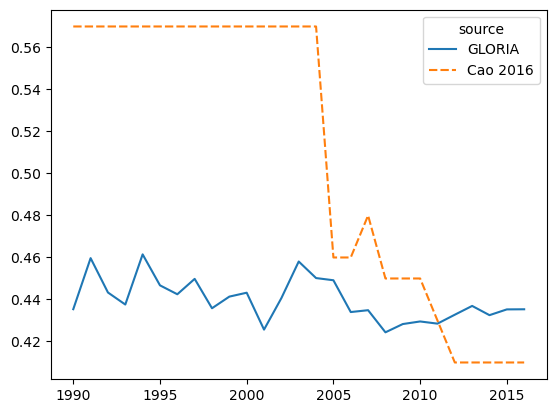

In [179]:
sns.lineplot(data=subset.T)

In [190]:
diffs = pd.DataFrame(gloria_subset_to_cao_subset_years.sort_index().values - joined_countries_subset_years.sort_index().values).set_index(gloria_subset_to_cao.index)

In [193]:
diffs = diffs.droplevel(1)

In [203]:
diffs = diffs.droplevel(2)

In [195]:
diffs.columns = np.arange(1990,2017)

In [214]:
buildings_differences = diffs.loc[:, "Buildings",:].copy()

In [226]:
buildings_differences["max_change"] = np.abs(buildings_differences.values).sum(axis=1)

In [227]:
buildings_differences = buildings_differences.sort_values("max_change")

In [229]:
buildings_differences = buildings_differences.drop("max_change",axis=1)

Text(0.5, 1.0, 'Differences GLORIA - Cao 2016')

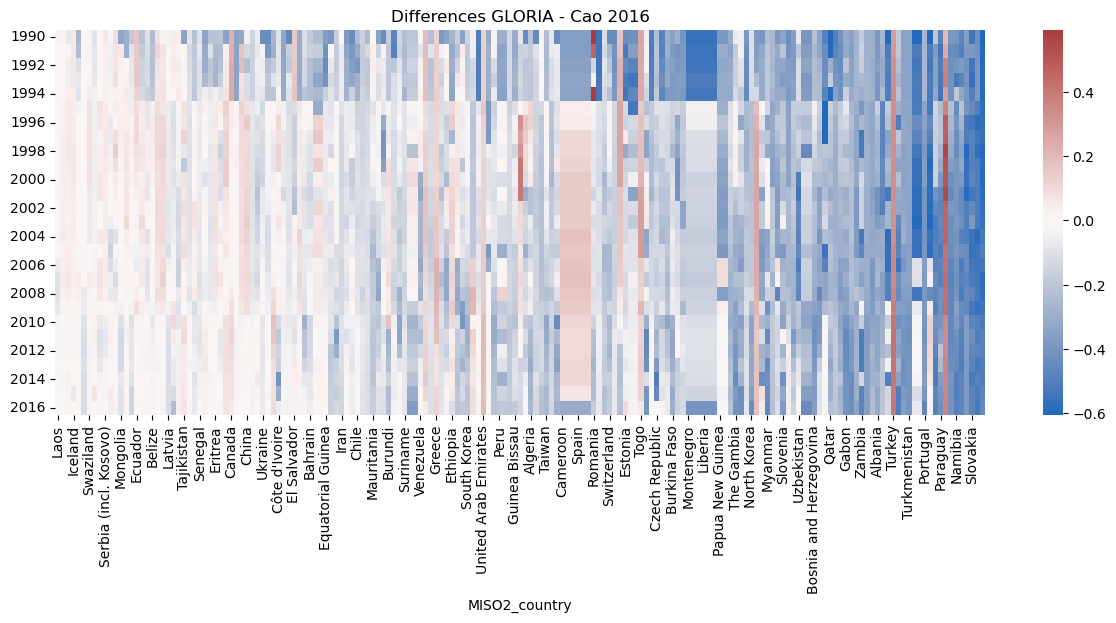

In [257]:
fig = plt.figure(figsize=(15,5))
ax = sns.heatmap(buildings_differences.T, cmap="vlag", center=0)
ax.set_title("Differences GLORIA - Cao 2016")

In [258]:
fig.savefig("heatmap_test.png", dpi=300)